## Leverage II: Rebalancing

In [1]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                          # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

Get prices:

In [2]:
PRICE       = tiingo.get_dataframe(['SPY'],'1900-01-01', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)

In [5]:
RET = PRICE.pct_change()
RET[-3:]

,SPY
2021-03-29,-0.000505
2021-03-30,-0.002653
2021-03-31,0.004053


In [6]:
fedfunds = quandl.get(['FRED/FEDFUNDS']).rename(columns={'FRED/FEDFUNDS - Value':'Fedfunds'}) / 100 / 252
fedfunds[-3:]

,Fedfunds
Date,
2020-12-01,0.000004
2021-01-01,0.000004
2021-02-01,0.000003


Assume margin rate equals fed funds rate + 100 basis points (1%):

In [7]:
RET = RET.join(fedfunds, how='outer')
RET['Fedfunds']   = RET.Fedfunds.ffill()
RET['MarginRate'] = RET.Fedfunds + 0.01/252
RET = RET.dropna()
RET

,SPY,Fedfunds,MarginRate
1993-02-01,0.007112,0.000120,0.000160
1993-02-02,0.002118,0.000120,0.000160
1993-02-03,0.010572,0.000120,0.000160
1993-02-04,0.004184,0.000120,0.000160
1993-02-05,-0.000696,0.000120,0.000160
...,...,...,...
2021-03-25,0.005626,0.000003,0.000043
2021-03-26,0.016115,0.000003,0.000043
2021-03-29,-0.000505,0.000003,0.000043
2021-03-30,-0.002653,0.000003,0.000043


In [9]:
weights = pd.Series({'SPY':1.5, 'MarginRate':-.5})
weights

SPY           1.5
MarginRate   -0.5
dtype: float64

Compound weighted average returns:

In [15]:
RET.multiply(weights).sum('columns').add(1).cumprod()

1993-02-01     1.010589
1993-02-02     1.013718
1993-02-03     1.029712
1993-02-04     1.036092
1993-02-05     1.034929
                ...    
2021-03-25    24.536645
2021-03-26    25.129230
2021-03-29    25.109653
2021-03-30    25.009192
2021-03-31    25.160715
Length: 7093, dtype: float64

Weighted average of compound returns:

In [17]:
RET.add(1).cumprod()

,SPY,Fedfunds,MarginRate
1993-02-01,1.007112,1.000120,1.000160
1993-02-02,1.009245,1.000240,1.000320
1993-02-03,1.019915,1.000361,1.000480
1993-02-04,1.024182,1.000481,1.000640
1993-02-05,1.023470,1.000601,1.000800
...,...,...,...
2021-03-25,15.059675,2.013265,2.667213
2021-03-26,15.302362,2.013272,2.667328
2021-03-29,15.294633,2.013278,2.667442
2021-03-30,15.254056,2.013285,2.667556


In [18]:
RET.add(1).cumprod().multiply(weights)

,Fedfunds,MarginRate,SPY
1993-02-01,NaN,-0.500080,1.510669
1993-02-02,NaN,-0.500160,1.513867
1993-02-03,NaN,-0.500240,1.529872
1993-02-04,NaN,-0.500320,1.536273
1993-02-05,NaN,-0.500400,1.535205
...,...,...,...
2021-03-25,NaN,-1.333607,22.589513
2021-03-26,NaN,-1.333664,22.953542
2021-03-29,NaN,-1.333721,22.941949
2021-03-30,NaN,-1.333778,22.881084


In [19]:
RET.add(1).cumprod().multiply(weights).sum('columns')

1993-02-01     1.010589
1993-02-02     1.013707
1993-02-03     1.029632
1993-02-04     1.035953
1993-02-05     1.034805
                ...    
2021-03-25    21.255907
2021-03-26    21.619879
2021-03-29    21.608228
2021-03-30    21.547306
2021-03-31    21.639995
Length: 7093, dtype: float64

Compare these two strategies:

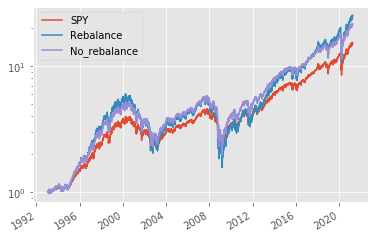

In [22]:
t = pd.DataFrame()

t['SPY']          = RET.SPY.add(1).cumprod()
t['Rebalance']    = RET.multiply(weights).sum('columns').add(1).cumprod()
t['No_rebalance'] = RET.add(1).cumprod().multiply(weights).sum('columns')

t.plot(logy=True)

Portfolio positions (dollars invested):

In [23]:
positions = RET.add(1).cumprod().multiply(weights)
positions

,Fedfunds,MarginRate,SPY
1993-02-01,NaN,-0.500080,1.510669
1993-02-02,NaN,-0.500160,1.513867
1993-02-03,NaN,-0.500240,1.529872
1993-02-04,NaN,-0.500320,1.536273
1993-02-05,NaN,-0.500400,1.535205
...,...,...,...
2021-03-25,NaN,-1.333607,22.589513
2021-03-26,NaN,-1.333664,22.953542
2021-03-29,NaN,-1.333721,22.941949
2021-03-30,NaN,-1.333778,22.881084


Leverage ratio:

In [28]:
(positions.SPY / positions.sum('columns'))

1993-02-01    1.494840
1993-02-02    1.493397
1993-02-03    1.485843
1993-02-04    1.482956
1993-02-05    1.483569
                ...   
2021-03-25    1.062741
2021-03-26    1.061687
2021-03-29    1.061723
2021-03-30    1.061900
2021-03-31    1.061638
Length: 7093, dtype: float64

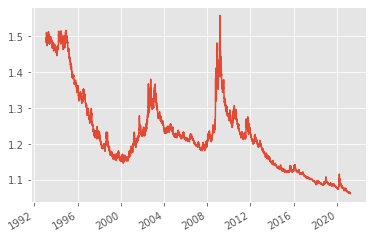

In [27]:
(positions.SPY / positions.sum('columns')).plot()

High water mark:

In [29]:
t.max()

SPY             15.315887
Rebalance       25.160715
No_rebalance    21.639995
dtype: float64

In [31]:
hwm = t.cummax()
hwm

,SPY,Rebalance,No_rebalance
1993-02-01,1.007112,1.010589,1.010589
1993-02-02,1.009245,1.013718,1.013707
1993-02-03,1.019915,1.029712,1.029632
1993-02-04,1.024182,1.036092,1.035953
1993-02-05,1.024182,1.036092,1.035953
...,...,...,...
2021-03-25,15.301625,25.137373,21.619174
2021-03-26,15.302362,25.137373,21.619879
2021-03-29,15.302362,25.137373,21.619879
2021-03-30,15.302362,25.137373,21.619879


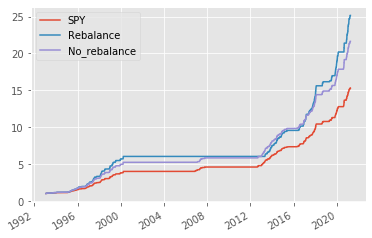

In [32]:
hwm.plot()

Portfolio drawdown:

In [34]:
drawdown = t/hwm
drawdown

,SPY,Rebalance,No_rebalance
1993-02-01,1.000000,1.000000,1.000000
1993-02-02,1.000000,1.000000,1.000000
1993-02-03,1.000000,1.000000,1.000000
1993-02-04,1.000000,1.000000,1.000000
1993-02-05,0.999304,0.998877,0.998891
...,...,...,...
2021-03-25,0.984188,0.976102,0.983197
2021-03-26,1.000000,0.999676,1.000000
2021-03-29,0.999495,0.998897,0.999461
2021-03-30,0.996843,0.994901,0.996643


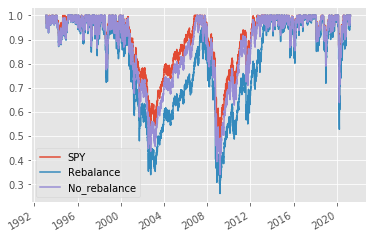

In [35]:
drawdown.plot()

#### With rebalance loop:

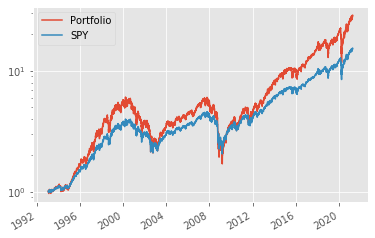

In [52]:
def get_rebalance_dates(frequency):
    group = getattr(PRICE.index, frequency) 
    return PRICE[:1].index.union(PRICE.groupby([PRICE.index.year, group]).tail(1).index)



def run_backtest(frequency):   

    weights = pd.Series({'SPY':1.5, 'MarginRate':-0.5})
    
    rebalance_dates = get_rebalance_dates(frequency)

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    leverage        = pd.Series(weights.SPY,                        index=[rebalance_dates[0]])
    
    trades          = pd.DataFrame(columns=weights.index, index=[rebalance_dates[0]])
    previous_positions = weights
    
    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        new_positions = portfolio_value.iloc[-1] * weights     

        start_to_end_positions = new_positions  * cum_ret

        portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))                  
        leverage = leverage.append(start_to_end_positions.SPY / start_to_end_positions.sum('columns'))
        
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value, leverage, trades


portfolio_value, leverage, trades = run_backtest('month')

portfolio_value.to_frame('Portfolio').join(RET.SPY.add(1).cumprod()).plot(logy=True)

Leverage:

In [53]:
leverage

1993-01-29    1.500000
1993-02-02    1.498536
1993-02-03    1.490878
1993-02-04    1.487951
1993-02-05    1.488573
                ...   
2021-03-25    1.480483
2021-03-26    1.469316
2021-03-29    1.469694
2021-03-30    1.471562
2021-03-31    1.468796
Length: 7093, dtype: float64

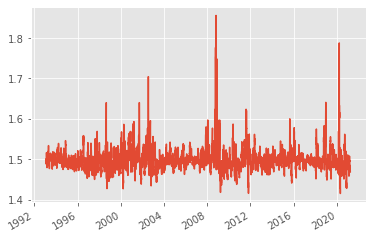

In [54]:
leverage.plot()

Cumulative trades:

In [56]:
trades.cumsum()

,SPY,MarginRate
1993-01-29,0,0
1993-02-26,0.000485592,-0.000485592
1993-03-31,0.0145576,-0.0145576
1993-04-30,-0.00788733,0.00788733
1993-05-28,0.00985297,-0.00985297
...,...,...
2020-10-30,7.72968,-7.72968
2020-11-30,9.45901,-9.45901
2020-12-31,10.1319,-10.1319
2021-01-29,9.91542,-9.91542


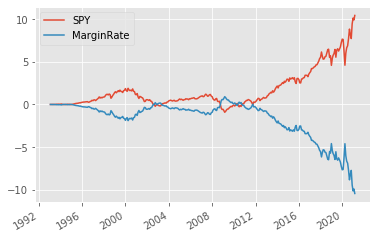

In [57]:
trades.cumsum().plot()

Annual turnover ratio:

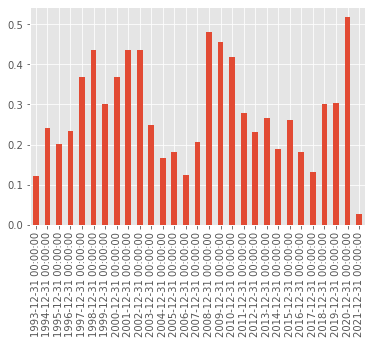

In [58]:
turnover = trades.abs().sum('columns').div(2)
turnover.resample('A').sum().div( portfolio_value.resample('A').mean() ).plot.bar()

Rebalance only when leverage too far away from target weights:
- leverage > 1.7: rebalance back to 1.5
- leverage < 1.3: rebalance back to 1.5
- else: do nothing

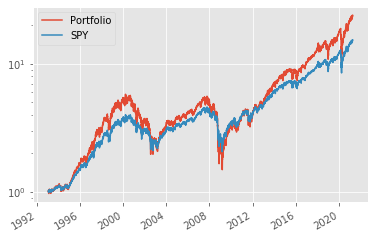

In [65]:
def get_rebalance_dates(frequency):
    group = getattr(PRICE.index, frequency) 
    return PRICE[:1].index.union(PRICE.groupby([PRICE.index.year, group]).tail(1).index)



def run_backtest(frequency):   

    weights = pd.Series({'SPY':1.5, 'MarginRate':-0.5})
    
    rebalance_dates = get_rebalance_dates(frequency)

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    leverage        = pd.Series(weights.SPY,                        index=[rebalance_dates[0]])
    
    trades          = pd.DataFrame(columns=weights.index, index=[rebalance_dates[0]])
    previous_positions = weights
    
    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
             
        if (leverage.iloc[-1]< 1.3) | (leverage.iloc[-1]>1.7):
            new_positions = portfolio_value.iloc[-1] * weights
        
        else:
            new_positions = previous_positions
            

        start_to_end_positions = new_positions  * cum_ret

        portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))                  
        leverage = leverage.append(start_to_end_positions.SPY / start_to_end_positions.sum('columns'))
        
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value, leverage, trades


portfolio_value, leverage, trades = run_backtest('month')

portfolio_value.to_frame('Portfolio').join(RET.SPY.add(1).cumprod()).plot(logy=True)

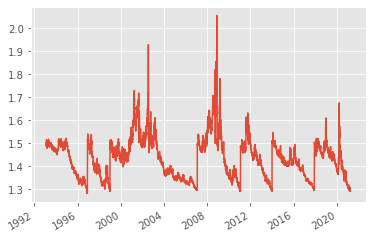

In [66]:
leverage.plot()

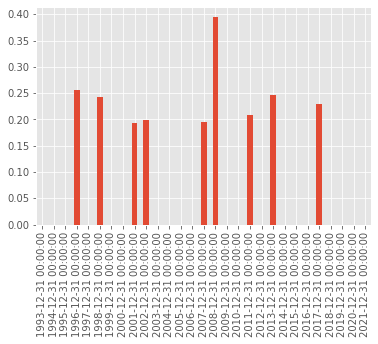

In [67]:
turnover = trades.abs().sum('columns').div(2)
turnover.resample('A').sum().div( portfolio_value.resample('A').mean() ).plot.bar()